##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [92]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
import LSTM
import Dense as Dense
importlib.reload(LSTM)
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
# pool.close()

In [93]:
FillVar = 'fco2'
FullModel = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg',
             'VPD','Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
print(len(FullModel))
Runs,params = Dense.Params('Test',FillVar,MP=False)# rpms.Runs,rpms.params
print(Runs)
print(params)

13
     N  MSE  STD   CI   SE
0    5  0.0  0.0  0.0  0.0
1   41  0.0  0.0  0.0  0.0
2   77  0.0  0.0  0.0  0.0
3  113  0.0  0.0  0.0  0.0
4  150  0.0  0.0  0.0  0.0
{'proc': 1, 'N_Max': 150, 'N_Min': 5, 'K': 4, 'epochs': 100, 'Y': 'fco2'}


In [114]:

def TTV_Split(i,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(Dense.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,i,X_fill = X_fill,Memory=Memory))

Time = time.time()
Path = 'Data_Footprints_2018-05-11.csv'

# plt.figure(figsize=(10,10))
def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    if params['T'] >0:
        RST.TimeShape(params['T'])
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MSE = []
#     STD = []
    Y_fill = []
    Yval = []
    y_val= []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['K']))):

            MSE.append(results[0])
            Y_fill.append(results[1])
            Yval.append(results[2])
            y_val.append(results[3])
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            MSE.append(results[0])
            Y_fill.append(results[1])
            Yval.append(results[2])
            y_val.append(results[3])
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0)
    
    Yval = np.asanyarray(Yval)
    Yval = Yval.mean(axis=0)
    y_val = np.asanyarray(y_val)
    y_val = y_val.mean(axis=0)
    
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)
#     if plot == True:
#         plt.scatter(RST.Master['TempFill'],RST.Master[FillVar],label=np.round(MSE.mean(),2))
#         yl = plt.ylim()
#         plt.xlim(yl)
        
    if FullReturn == False:
        return(MSE,RST.Master['TempFill'])
    else:
        return(MSE,RST.Master)

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Runs.index:
    try:
        params['T']=Runs['T'].iloc[i]
    except:
        params['T'] = 0
    params['N']=Runs['N'].iloc[i]
    Results = RunReps(FullModel,params,pool,plot=True)
    MSE = Results[0]
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    Runs['SE'][i]=MSE.std()/(params['K']**.5)
    print('Finisehed Run ',str(i),' MSE: ',MSE.mean())

# plt.grid()
# plt.legend()
Runs['CI'] = Runs['STD']/params['K']**.5*stats.t.ppf(1-0.05, params['K']-2)
# try:
#     plt.figure(figsize=(10,10))
#     plt.scatter(Runs['N'],Runs['T'],c = Runs['MSE'],s=Runs['STD']*1e4)
# except:
#     plt.figure(figsize=(10,10))
#     plt.bar(Runs['N'],Runs['MSE'],yerr=Runs['CI'])


def Curve(x,a,b,c):
    return (a*x**2+b*x+c)

popt, pcov = curve_fit(Curve, Runs['N'].values, Runs['MSE'].values)

# fig,ax = plt.subplots(figsize = (8,8))
# ax.plot(Runs['N'],Curve(Runs['N'],*popt))
# ax.bar(Runs['N'],Runs['MSE'],yerr=Runs['SE'])
# Min = Runs.loc[Runs['MSE']==Runs['MSE'].min()]
# ax.plot(Runs['N'],Runs['MSE']*0+(Min['MSE']+Min['SE']))
print(time.time()-Time)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finisehed Run  0  MSE:  0.163613015735
Finisehed Run  1  MSE:  0.0955465900272
Finisehed Run  2  MSE:  0.0980798441601
Finisehed Run  3  MSE:  0.0927819361725
Finisehed Run  4  MSE:  0.0908429776918
658.4916281700134


63


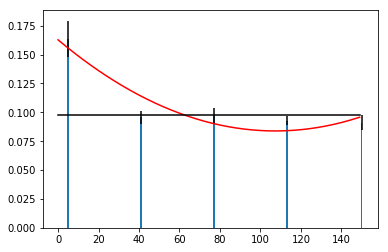

In [112]:
fig,ax = plt.subplots()
ax.bar(Runs['N'],Runs['MSE'],yerr=Runs['SE'])

N = np.arange(0,150)
Fit = Curve(N,*popt)
ax.plot(N,Fit,color='r')
Min = Runs.loc[Runs['MSE']==Runs['MSE'].min()]
Max = (Min['MSE']+Min['SE']).values[0]
ax.plot(N,N*0+Max,color = 'black')
params['N']=N[Fit<Max].min()
plt.show()

# Feature Identification

In [67]:

# FullModel = ['H','wind_speed','air_pressure','Sedge']
# print(len(FullModel))
# # # Runs,params = Dense.Params('Test',FillVar,MP=False)# rpms.Runs,rpms.params
# # Runs['MSE'] = 0.0
# # Runs['STD'] = 0.0
# # Runs['CI'] = 0.0
# # print(Runs)
# # params['epochs'] = 20
params['K'] = 4

# params['T']=0
# params['N']=100

FullModel = ['PPFD_Avg','wind_speed','air_pressure','Sedge']#,'Temp']
params['Y']='fch4'
# # print(params)

In [72]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

# def TTest(Best,Past_Best,p):
# #     print((Best, Past_Best))
# #     Best = 
#     Res = stats.ttest_ind(Best, Past_Best,equal_var =False)
#     print()
#     print(Res[1],Best.mean(),Past_Best.mean())
#     if Best.mean()<Past_Best.mean() and Res[1] < p:
#         return('Y')
#     else:
#         return('N')
    
def Tukeys(Names,Values,Best,Past_Best = None, p = .2):
    Best = list(Best)
    d = {'Model':Names,'MSE':Values}
    Data = pd.DataFrame(data=d)
#     if Past_Best is not None:
# #         print(Best)
#         KeepGoing = TTest(Data.loc[Data['Model']==Best[0],'MSE'].values,Past_Best,p)
#     else:
#         KeepGoing = 'Y'
    posthoc = pairwise_tukeyhsd(
        Data['MSE'], Data['Model'],
        alpha=p)
    c = 0
    print(posthoc)
    for i,val in enumerate(posthoc.groupsunique):
        for j,vayl in enumerate(posthoc.groupsunique[i+1:]): 
            if posthoc.reject[c] == False:
                if vayl == Best[0]:
                    Best.append(val)
                if val == Best[0]:
                    Best.append(vayl)
            c+=1

    if i > 1:
        fig = posthoc.plot_simultaneous()
#     if KeepGoing == 'Y':
    return(Best)
#     else:
#         return(['N'],'')

Level:  1
[['PPFD_Avg'], ['wind_speed'], ['air_pressure'], ['Sedge']]
['PPFD_Avg'] 0.840375902861
['wind_speed'] 0.85325835859
['air_pressure'] 0.84706746913
['Sedge'] 0.762547350274
   Multiple Comparison of Means - Tukey HSD,FWER=0.20   
   group1       group2    meandiff  lower  upper  reject
--------------------------------------------------------
  PPFD_Avg      Sedge     -0.0778  -0.1827 0.027  False 
  PPFD_Avg   air_pressure  0.0067  -0.0982 0.1115 False 
  PPFD_Avg    wind_speed   0.0129   -0.092 0.1177 False 
   Sedge     air_pressure  0.0845  -0.0203 0.1894 False 
   Sedge      wind_speed   0.0907  -0.0141 0.1956 False 
air_pressure  wind_speed   0.0062  -0.0987 0.111  False 
--------------------------------------------------------
['Sedge']
Level:  2
[['PPFD_Avg', 'Sedge'], ['wind_speed', 'Sedge'], ['air_pressure', 'Sedge']]
['PPFD_Avg', 'Sedge'] 0.748767160672
['wind_speed', 'Sedge'] 0.729044574362
['air_pressure', 'Sedge'] 0.674359098745
          Multiple Comparison of M

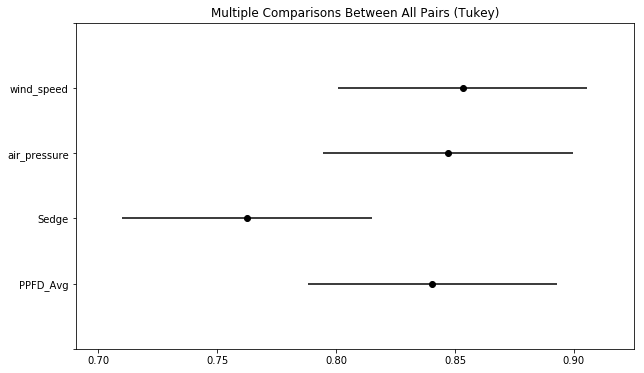

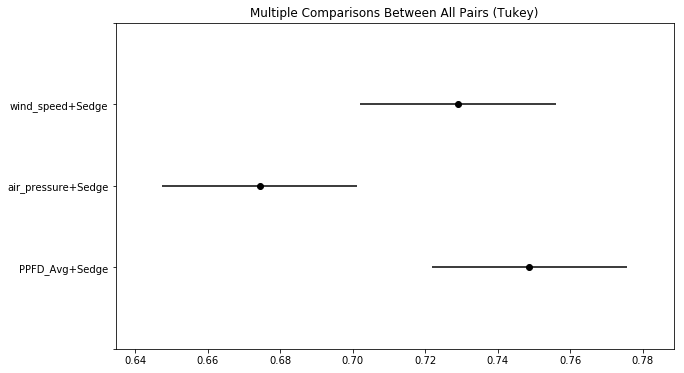

In [73]:
def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    print (Models)
    return(Models)
try:
    params['T']=Optimum['T'].values[0]
except:
    pass
# params['N']=Optimum['N'].values[0]
Scores = Optimum[['MSE','CI','Upper_Bounds','STD']].reset_index(drop=True)
Scores['Level'] = len(FullModel)
Scores['Key'] = str(Scores['Level'][0])+'_0'
Scores['Model'] = '+'.join(FullModel)
Scores['Best'] = 'N'

Results = RunReps(FullModel,params,pool)
ModelRuns = Results[1]
ModelRuns = ModelRuns.to_frame()
ModelRuns.rename(columns={'TempFill':'+'.join(FullModel)})

for i in range(1,len(FullModel)):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
    Values = []
    Names = []
    for i,model in enumerate(Models):
        level = len(model)
        key = str(level)+'_'+str(i)
        Name = '+'.join(model)
        NewRow = Scores.iloc[-1].copy()
        NewRow['Model'] = 'Model: '+Name
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        for mse in MSE:
            Names.append(Name)
            Values.append(mse)
        mean,std = MSE.mean(),MSE.std()
        CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
        d = {'Model':'+'.join(model),'MSE':mean,'STD':std,'Level':level,
             'CI':CI,'Upper_Bounds':mean+CI,'Key':key,'Best':'N'}
        score = pd.DataFrame(index=[0],data=d)
        print(model,mean)
        Scores = Scores.append(score,ignore_index=True)
        ModelRuns['Model: '+'+'.join(model)] = Results[1]    
    
    Min = Scores.loc[Scores['Level']==level]
    Min = Min.loc[Min['MSE'] == Min['MSE'].min(),'Model'].values
    Best = Tukeys(Names,Values,Min)
    Scores.loc[Scores['Model'].isin(Best),'Best']='Y'
    Best = Min
    print(Best)

Scores.to_csv('GapFillingSummary'+FillVar+'.csv')
ModelRuns.to_csv('GapFilled'+FillVar+'.csv')

In [ ]:

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)
        